In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
from sklearn import utils

import tensorflow as tf


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [29]:
# Merkmalsreduktion
# Schneide irrelevante Informationen aus dem Bilder heraus.
# Speichere die Merkalsreduzierten Bilder in einen neuen Ordner /data/

all_dogs = 0  # Zählvariable der Hundebilder 
data_dir = os.getcwd() + '\\'
breed_list = os.listdir(data_dir + 'images\\Images\\')
os.makedirs('data', exist_ok=True)


for breed in breed_list:
    os.makedirs('data\\' + breed, exist_ok=True)
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotation\\Annotation\\' + breed):
        img = Image.open(data_dir + 'images\\Images\\' + breed + '\\' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotation\\Annotation\\' + breed + '\\' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data//' + breed + '/' + file + '.jpg')
        all_dogs = all_dogs+1

In [30]:
#lese daten  in "bilder aka imagepath array ein und der dazugehörigen daten aka label_array"
# Speichere die Bilddaten (RGB Werte) in ein array
# Speichere die Hunderassen in 
SCALE = 32 # Setzte Skalierungsfaktor auf welchen die Bilder alle Skaliert werden
data_array = []
label_array= []
breedNum = 0
for breed in breed_list:
    imagepath=(data_dir + 'data\\' + breed )
    for img in os.listdir(imagepath):
        img_array=cv2.imread(os.path.join(imagepath,img))
        #data_array.append(img_array.tolist())
        data_array.append(cv2.resize(img_array,(SCALE,SCALE)).tolist())
        label_array.append(breedNum) # Setze Hunderasseart auf eine ID
    breedNum = breedNum + 1

In [31]:
# Umbennenen der Hunderassen. (Scheide Ziffern weg) 
# Zu besseren Darstellung in den Legenden der folgenden Schaubilder
for i in range(0, len(breed_list)):
    ar = breed_list[i].split('-')
    breed_list[i] = ar[1]

In [32]:
#### Schuffel einschalten###
## hier werden nicht mehr die Features wie in Aufgabe 1 sondern die Rohdaten das Bild in sich als Daten genommen

label_array, data_array = utils.shuffle(label_array, data_array)
# Einteilen der TEST und TRAIN Daten
size_of_train= int(all_dogs*0.75)
size_of_test = int(all_dogs*0.25)
X_train = np.array(data_array[:size_of_train])
Y_train = np.array(label_array[:size_of_train])
X_test = np.array(data_array[-size_of_test:])
Y_test = np.array(label_array[-size_of_test:])


In [33]:
# Shape die Daten zurecht
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_train=X_train / 255.0
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_test=X_test / 255.0

Y_train = tf.one_hot(Y_train.astype(np.int32), depth=5)
Y_test = tf.one_hot(Y_test.astype(np.int32), depth=5)


In [34]:
batch_size = 32
num_classes = 5  ## (Anzahl der Hunderassen)
epochs = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.30),

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.30),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax'),

    
 ])
model.compile(optimizer="adam",
            loss='categorical_crossentropy', metrics=['acc'])

#model.summary()


In [35]:
history =model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          )

Epoch 1/10
20/20 [==============================] - 1s 18ms/step - loss: 1.6223 - acc: 0.2739
Epoch 2/10
20/20 [==============================] - 0s 18ms/step - loss: 1.3308 - acc: 0.4178
Epoch 3/10
20/20 [==============================] - 0s 18ms/step - loss: 1.0595 - acc: 0.5603
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.9615 - acc: 0.5994
Epoch 5/10
20/20 [==============================] - 0s 18ms/step - loss: 0.8092 - acc: 0.6651
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.7662 - acc: 0.6714
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6520 - acc: 0.7293
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6067 - acc: 0.7559
Epoch 9/10
20/20 [==============================] - 0s 19ms/step - loss: 0.5904 - acc: 0.7574
Epoch 10/10
20/20 [==============================] - 0s 19ms/step - loss: 0.5562 - acc: 0.7668


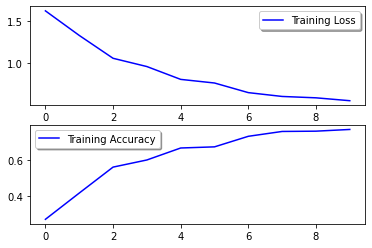

In [36]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [37]:
## Evalierungstest des CNN mit den TEST Daten
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5948073267936707
Test accuracy: 0.7652581930160522


In [38]:
# Führe die Kreuzvalidierung durch
from sklearn.model_selection import KFold

# Definiere die Anzahl der Folds
num_folds = 3

# Erstelle ein int, um die Genauigkeit für jeden Fold zu speichern
acc =0

# Teile das Modell in Folds auf
folds = KFold(n_splits=num_folds, shuffle=True)


x_data = X_train
y_data = X_train

# Führe die Kreuzvalidierung durch
for train_index, test_index in folds.split(X_train):
    train_index = train_index.flatten()
    test_index = test_index.flatten()

    # Verwende die Indizes, um die Trainings- und Testdaten aufzuteilen
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]


    model.fit(X_train, Y_train, epochs=3, verbose=0)
    accuracy = model.evaluate(X_test, Y_test)
    print(accuracy[1])
    acc = acc +accuracy[1]
# Berechne die Durchschnittsgenauigkeit
print("\nDurchschnittsgenauigkeit nach"+str(num_folds)+"-Fold-Validierung:", (acc / num_folds))


7/7 [==============================] - 0s 8ms/step - loss: 0.5455 - acc: 0.8028
0.8028169274330139
7/7 [==============================] - 0s 6ms/step - loss: 0.5224 - acc: 0.8075
0.8075117468833923
7/7 [==============================] - 0s 5ms/step - loss: 0.4629 - acc: 0.8310
0.8309859037399292
Durchschnittsgenauigkeit nach3-Fold-Validierung: 0.8137715260187784


 X-Achse = Predicted Labeles Y-Achse = die wahren Labels 


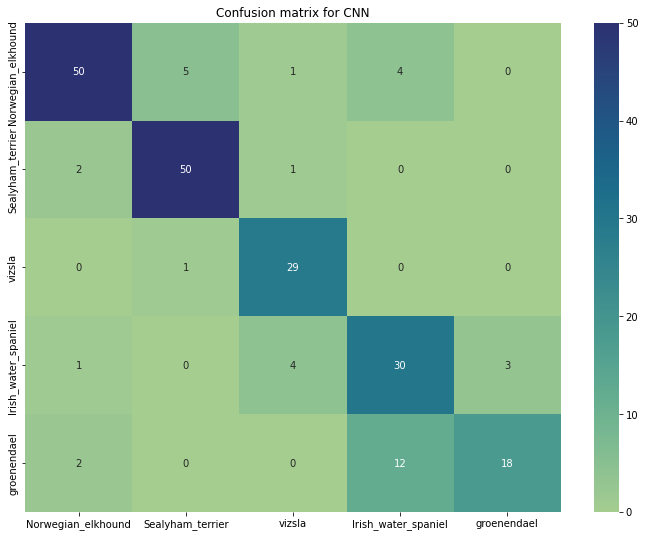

In [41]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test,verbose=0)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors

y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap="crest")
c.set(xticklabels=breed_list, yticklabels=breed_list)
c.set_title("Confusion matrix for CNN") 
print(" X-Achse = Predicted Labeles Y-Achse = die wahren Labels ")

